In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
# nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [2]:
# import data
raw_data =  pd.read_csv('../raw-data/skills_test.csv')

In [3]:
raw_data.head()

,Text,label
0,I bought a car through a dealership and had so...,1
1,"April 7, 2006 Wells Fargo Bank announced they ...",1
2,Securities watchdog investigates Wells Fargo o...,1
3,I had a problem where for months my student lo...,1
4,If someone opens a bank account without your k...,1


In [4]:
# Check balance of the two classes
print(raw_data[raw_data['label'] == 0]['label'].count())
print(raw_data[raw_data['label'] == 1]['label'].count())

1914
1914


In [5]:
def clean_text(s):
    """
    Pre-process text data by removing stop words, puncuation and strange characters
    
    return string
    """
    symbols_re = re.compile('[^a-z #+_]')
    space_re = re.compile('[/(){}\[\]\|@,;]')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower()
    s = symbols_re.sub('', s)
    s = space_re.sub(' ', s)
    s = ' '.join([l for l in s.split() if l not in stopwords.words('english')])
    return s

In [6]:
def plot_cm(cf):
    """
    Plot the confusion matrix
    """
    plt.matshow(cf)
    plt.title('Confusion Matrix Plot')
    plt.colorbar()
    plt.xlabel('Precited')
    plt.ylabel('Actual')
    plt.show()

In [26]:
def tokenize_CountVectorizer(text_train, text_test, all_text):
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=None)
    vectorizer.fit(text_train)
    X_train = vectorizer.transform(text_train)
    X_test  = vectorizer.transform(text_test)
    text_vects = vectorizer.transform(all_text)
    return X_train, X_test, text_vects 

In [8]:
def tokenize_tfidf(text_train, text_test, all_text):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text_train)
    X_train = vectorizer.transform(text_train)
    X_test  = vectorizer.transform(text_test)
    text_vects = vectorizer.transform(all_text)
    return X_train, X_test, text_vects 

In [10]:
def classifier(classifier_method, X_train, X_test, y_train, y_test, text_vects):
# nb = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', MultinomialNB()),
#               ])

    classifier = classifier_method
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    cf = confusion_matrix(y_test, y_pred)
    scores = cross_val_score(classifier, text_vects, raw_data['label'], cv=10)
    print('Average score from cross-validation {}'.format(scores.mean()))
    plot_cm(cf)
    return

In [11]:
# logger.info('cleaning text, this may take 1-2 minutes...')
raw_data['Text'] = raw_data['Text'].apply(clean_text)

split the data into training set and test set using scikitlearn

In [27]:
x = raw_data['Text']
y = raw_data['label']
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [28]:
X_train, X_test, text_vects = tokenize_CountVectorizer(text_train, text_test, raw_data['Text'])

In [33]:
X_train, X_test, text_vects = tokenize_tfidf(text_train, text_test, raw_data['Text'])

accuracy 0.762402088772846
              precision    recall  f1-score   support

           0       0.96      0.57      0.71       597
           1       0.68      0.97      0.80       552

    accuracy                           0.76      1149
   macro avg       0.82      0.77      0.75      1149
weighted avg       0.82      0.76      0.75      1149

Average score from cross-validation 0.8354357547993019


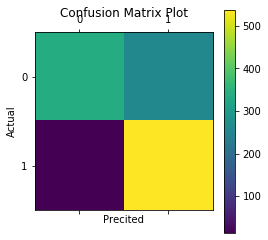

In [14]:
## Naive Bayes Classifier for Multinomial Models
classifier(MultinomialNB(), X_train, X_test, y_train, y_test, text_vects)

accuracy 0.9303742384682332
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       597
           1       0.92      0.93      0.93       552

    accuracy                           0.93      1149
   macro avg       0.93      0.93      0.93      1149
weighted avg       0.93      0.93      0.93      1149

Average score from cross-validation 0.9462041884816754


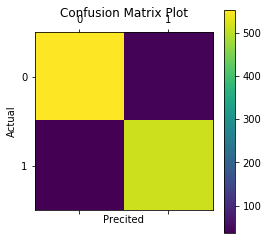

In [15]:
# Linear Support Vector Machine
classifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None), 
           X_train, X_test, y_train, y_test, text_vects)

accuracy 0.9564838990426457
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       597
           1       0.96      0.95      0.95       552

    accuracy                           0.96      1149
   macro avg       0.96      0.96      0.96      1149
weighted avg       0.96      0.96      0.96      1149

Average score from cross-validation 0.9532613438045375


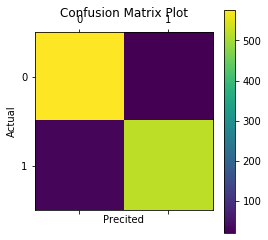

In [16]:
## Linear Support Vector Machine
classifier(LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=200),
           X_train, X_test, y_train, y_test, text_vects)

accuracy 0.9825935596170583
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       597
           1       1.00      0.97      0.98       552

    accuracy                           0.98      1149
   macro avg       0.98      0.98      0.98      1149
weighted avg       0.98      0.98      0.98      1149

Average score from cross-validation 0.9723222076788831


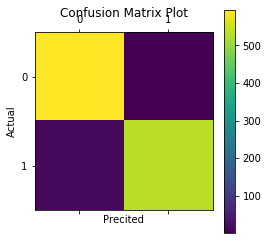

In [17]:
## Decision Tree
classifier(DecisionTreeClassifier(max_depth=10,random_state=0), 
           X_train, X_test, y_train, y_test, text_vects)

accuracy 0.9112271540469974
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       597
           1       0.94      0.87      0.90       552

    accuracy                           0.91      1149
   macro avg       0.91      0.91      0.91      1149
weighted avg       0.91      0.91      0.91      1149

Average score from cross-validation 0.8913244437172775


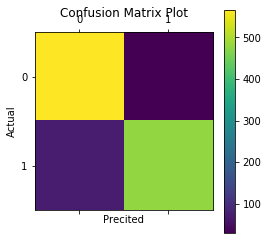

In [18]:
## Random Forrest Classifier
classifier( RandomForestClassifier(n_estimators=10, max_depth=None,random_state=0),
           X_train, X_test, y_train, y_test, text_vects)

## Neural Networks in Keras with Tensorflow in the backend

In [29]:
num_feat = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=num_feat, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                142310    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 142,321
Trainable params: 142,321
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [32]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9225


In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

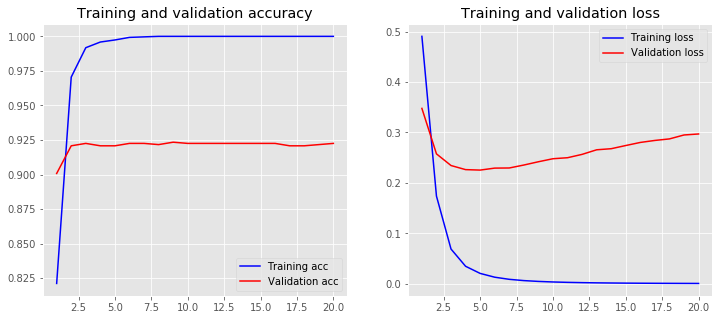

In [34]:
plot_history(history)